# Noise2Void on 3D Patches applied to Refined Dataset

In this experiment we trained a model on the REFINED train set, using no augmentations and a 3D patch size of 64x64x64. 

The following command was used to train the model:

```bash
python n2v_train.py 
-e .env_hpc 
--level DEBUG 
--train_dataset_name=train 
--validation_dataset_name=val 
--DATASET_FOLDER=/scratch/edoardo.giacomello/calcium_imaging/refined 
--experiment_name=REFINED_N2V_3 
--patch_size_z=64 
--batch_size=1 
--axes=ZYX
```

Predictions were made on the train set to enable further models to be trained on the predictions. The following command was used to make predictions:

```bash
python n2v_predict.py
 -e .env_hpc 
 --level DEBUG 
 --dataset_name=train 
 --DATASET_FOLDER=/scratch/edoardo.giacomello/calcium_imaging/refined 
 --experiment_name=REFINED_N2V_3 
 --patch_size_z=64 
 --batch_size=4 
 --axes=ZYX
```

# Model Output

Showing the input image, the model output and the model output with the microscope background noise subtracted from it.

In [1]:
import tifffile
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

EXPERIMENT_NAME = "REFINED_N2V_3"

input_image = tifffile.imread("/localscratch/calcium_imaging_dataset/calcium_imaging/refined/test/20ms_20%_Yoda1_009.tif")
output_image = tifffile.imread(f"output/{EXPERIMENT_NAME}/test/20ms_20%_Yoda1_009.tif")
average_noise = tifffile.imread("/localscratch/calcium_imaging_dataset/calcium_imaging/average_image.tif")
stacked_to_show = np.stack([input_image, output_image, output_image-average_noise])

In [ ]:
from view_utils import display_image_with_slider

display_image_with_slider(stacked_to_show, vlim="stack", titles=["Input Image", "Output of 3D Noise2Void", "Output without Average Microscopy Noise"], figsize=(12, 4))


interactive(children=(IntSlider(value=0, description='T', max=1008), Output()), _dom_classes=('widget-interact…

## Noise over Time

From the outputs of the network we can see that some spatial noise (mostly spatially-correlated noise) is still present. However, if we consider just the time dimension for a given x, y location in the image we can see that the fluctuations in the pixel values are greatly reduced while conserving most of the visual information content of the flickering dynamics.

interactive(children=(IntSlider(value=0, description='T', max=1008), Output()), _dom_classes=('widget-interact…

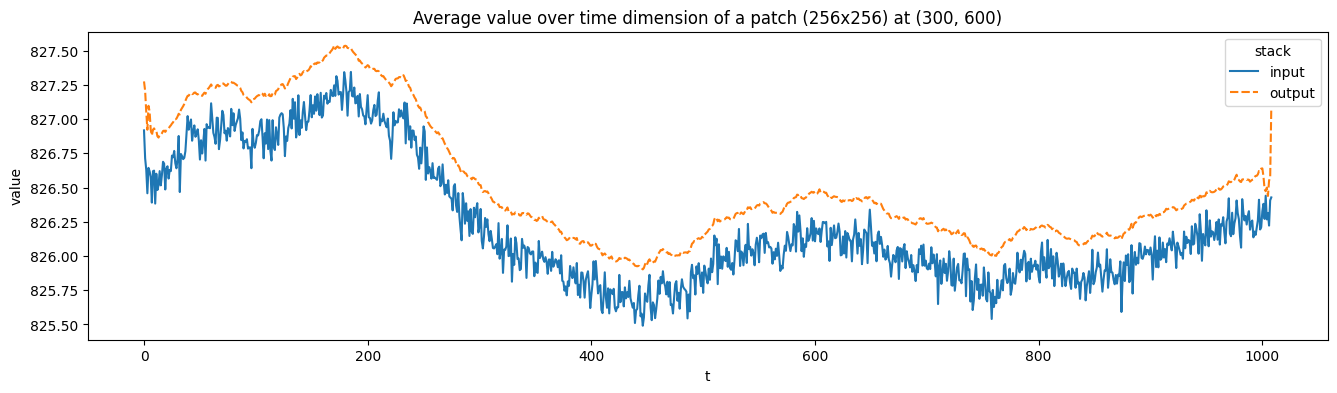

In [ ]:
import random
import seaborn as sns
import pandas as pd
import numpy as np

patch_size = 256

# Select a random top-left corner for the patch
#x, y = random.randint(0, input_image.shape[1] - patch_size), random.randint(0, input_image.shape[2] - patch_size)
x, y = 300, 600


# Input patches
input_patch = input_image[:, x:x+patch_size, y:y+patch_size]
output_patch = output_image[:, x:x+patch_size, y:y+patch_size]

# Display input patches
display_image_with_slider(np.stack([input_patch, output_patch]), vlim="stack", titles=["Input Patch", "Output Patch"])

# Extract the patch and compute the average over the spatial dimensions
input_avg = input_patch.mean(axis=(1, 2))
output_avg = output_patch.mean(axis=(1, 2))

# Prepare the data for plotting
data = pd.DataFrame({"input": input_avg, "output": output_avg})
data = data.reset_index(names=["t"]).melt(id_vars=["t"], var_name="stack")

# Plot
plt.figure(figsize=(16, 4))
g = sns.lineplot(data=data, x="t", y="value", hue="stack", style="stack")
g.set_title(f"Average value over time dimension of a patch ({patch_size}x{patch_size}) at ({x}, {y})")
plt.show()





## Temporal Shift Detection
To assess whether our denoising model introduces a temporal delay in calcium flickering events, we perform a cross-correlation analysis between the input and output signals.  \
We first extract the average intensity of a randomly selected patch across the time dimension and compute its temporal cross-correlation with the corresponding denoised output. \
By analyzing the lag at which the cross-correlation function reaches its maximum, we determine whether the model shifts the signal in time. \
If the peak occurs at lag = 0, the model preserves the temporal dynamics; a nonzero peak suggests a delay or advancement of flicker events due to the 3D model input.

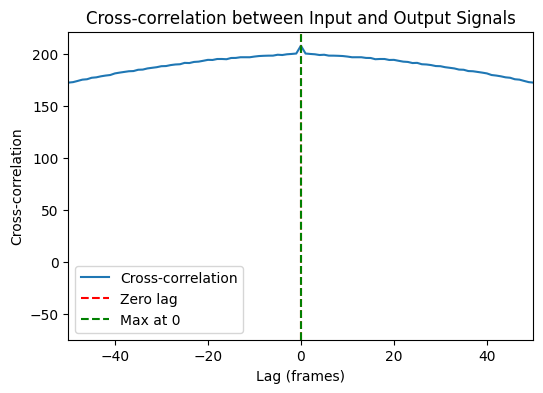

In [13]:
from scipy.signal import correlate
# Compute cross-correlation
lags = np.arange(-len(input_avg) + 1, len(input_avg))
cross_corr = correlate(output_avg - output_avg.mean(), input_avg - input_avg.mean(), mode="full")

# Find the lag at which cross-correlation is maximum
max_lag = lags[np.argmax(cross_corr)]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(lags, cross_corr, label="Cross-correlation")
plt.axvline(0, color="red", linestyle="--", label="Zero lag")
plt.axvline(max_lag, color="green", linestyle="--", label=f"Max at {max_lag}")
plt.xlabel("Lag (frames)")
plt.ylabel("Cross-correlation")
plt.xlim(-50, +50)
plt.legend()
plt.title("Cross-correlation between Input and Output Signals")
plt.show()


## Insights on denoising performances

Analyzing the temporal standard deviation (tSTD) per pixel provides insights about the denoising performances of the 3D N2V model. \
In the raw input images, tSTD reflects both the natural variability of data and noise. \
If the model preserves the signal dynamics, the tSTD map of the denoised output should only report significant STD in the brightest regions of the input tSTD. \
Conversely, if the denoised tSTD map is overly smooth, it may indicate that the model fails to reproduce calcium flickering events. \

By analysing the squared error between the input and the denoised tSTD maps, we observe that the model successfully removes noise in most spatial locations, as shown by the homogeneous intensity of the error map. \
However, certain areas corresponding to flickering events are darker, suggesting that the model may be over-compressing temporal dynamics. \
Moreover, regions with substantial deviations between input and denoised tSTD maps - i.e., brighter spots in the SE map - may indicate either a failure in accurately reconstructing specific flickering events or the influence of Poisson noise in the data.

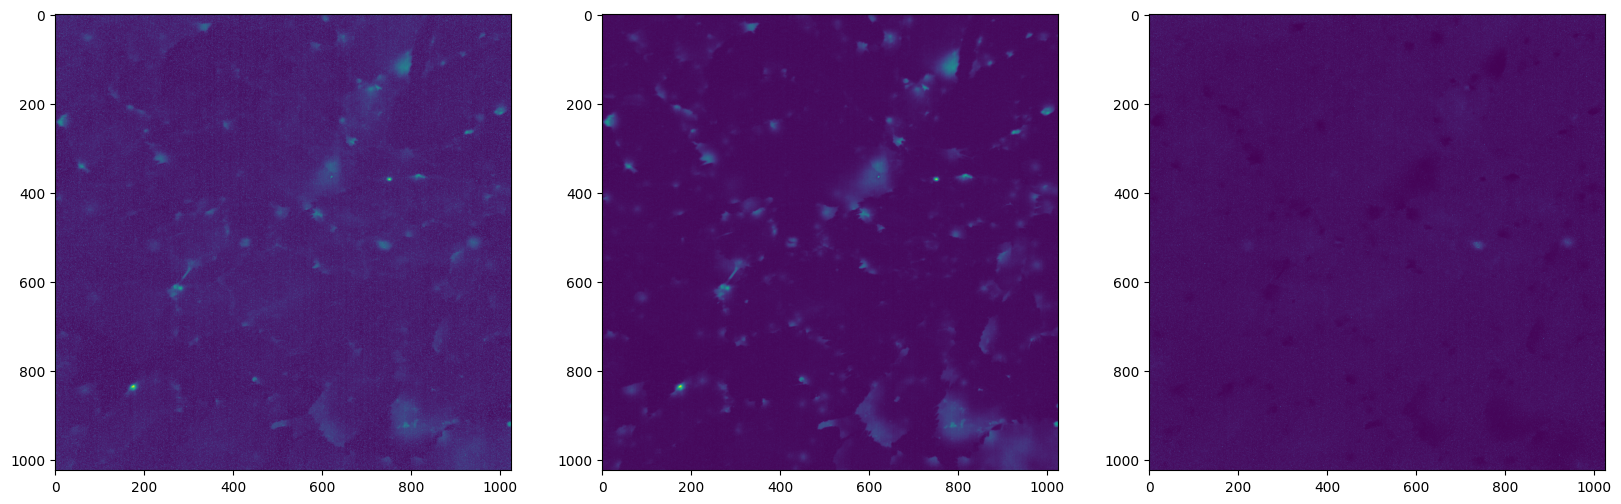

In [12]:
std_to_show = np.stack([input_image.std(axis=0), output_image.std(axis=0), np.pow(input_image.std(axis=0) - output_image.std(axis=0), 2)])

fig, axs = plt.subplots(1, 3, squeeze=False, figsize=(20, 10))
for ax, img in zip(axs[0], std_to_show):
    ax.imshow(img)
fig.show()

# Preview Export

In [ ]:
import tifffile
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from view_utils import create_gif_from_numpy

EXPERIMENT_NAME = "REFINED_N2V_3"

input_image = tifffile.imread("/localscratch/calcium_imaging_dataset/calcium_imaging/refined/test/20ms_20%_Yoda1_009.tif")
output_image = tifffile.imread(f"output/{EXPERIMENT_NAME}/test/20ms_20%_Yoda1_009.tif")
average_noise = tifffile.imread("/localscratch/calcium_imaging_dataset/calcium_imaging/average_image.tif")

create_gif_from_numpy(output_image, f"docs/experiments_preview/{EXPERIMENT_NAME}.gif", scale_factor=0.5, frame_skip=20)
create_gif_from_numpy(output_image - average_noise, f"docs/experiments_preview/{EXPERIMENT_NAME}_noavg.gif", scale_factor=0.5, frame_skip=20)